<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/VGG_DBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras,os
import cv2
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate

In [4]:
!unzip -qq images.zip

In [5]:
!unzip -qq labels.zip

In [6]:
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:6000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return class_label,label,total_img

In [7]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [8]:
total_images.shape

(6000, 224, 224, 3)

In [64]:
def vggnet():
    layer_in = Input(shape=(224, 224, 3))
    #layer 1
    layer = layers.Conv2D(64,(3,3),padding="same", activation="relu")(layer_in)
    layer =layers.Conv2D(64,(3,3),padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D((2,2),strides=(2,2))(layer)
    layer =layers.Conv2D(64,(1,1),padding="same")(layer)
    #layer 2
    layer = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    #layer 3
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    layer =layers.Conv2D(256,(1,1),padding="same")(layer)
    #layer 4
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    layer =layers.Conv2D(512,(1,1),padding="same")(layer)
    # layer 5
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    layer =layers.Conv2D(512,(1,1),padding="same")(layer)
    #layer = layers.Conv2D(filters=3, kernel_size=(3,3), padding="same", activation="sigmoid")(layer)
    layer = layers.UpSampling2D(size=(32, 32))(layer)#upsampling
    main = layers.Conv2D(filters=3, kernel_size=(3,3), padding="same", activation="sigmoid",name="main")(layer)
    model = Model(inputs=layer_in, outputs=main)
    return model

In [65]:
model=vggnet()
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_116 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_117 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_118 (Conv2D)         (None, 112, 112, 64)      4160      
                                                                 
 conv2d_119 (Conv2D)         (None, 112, 112, 128)     73856     
                                                           

In [1]:
loss="binary_crossentropy"
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss],metrics=["accuracy"])

NameError: ignored

In [ ]:
class_label=class_labels[:5000]
x_train = total_images[:5000].astype(np.float32)/ 255.0
y_train=total_labels[:5000].astype(np.float32)/ 255.0
y_train =(y_train,class_label)

In [63]:
history = model.fit(x_train,y_train[0], epochs=10,batch_size=20, validation_split=0.2,shuffle=True)
model.save('vggdbm_model.h5')

Epoch 1/10


ResourceExhaustedError: ignored

In [40]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [16]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'vgg-dbm-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

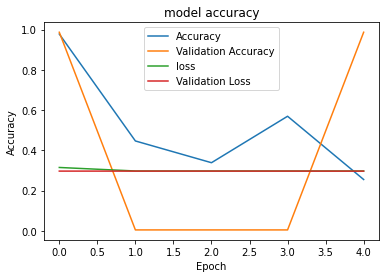

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [19]:
eval_images=total_images[5000:]
eval_labels=total_labels[5000:]
eval_class_label=class_labels[5000:]

In [42]:
from keras.models import load_model
from PIL import Image
images = eval_images
model = load_model("vggdbm_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [43]:
#predictions[0][0]

In [44]:
def get_iou_score(predictions,eval_labels):
  iou_scores=[]
  for i in range(len(predictions)):
    true_label = eval_labels[i]/255.0
    y_pred_label = np.where((((predictions[i])[0]))>0.5,1.0,0.0)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label, y_pred_label)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)

In [45]:
iou_score = get_iou_score(predictions,eval_labels)

In [46]:
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.6895486


predicted class vs true class


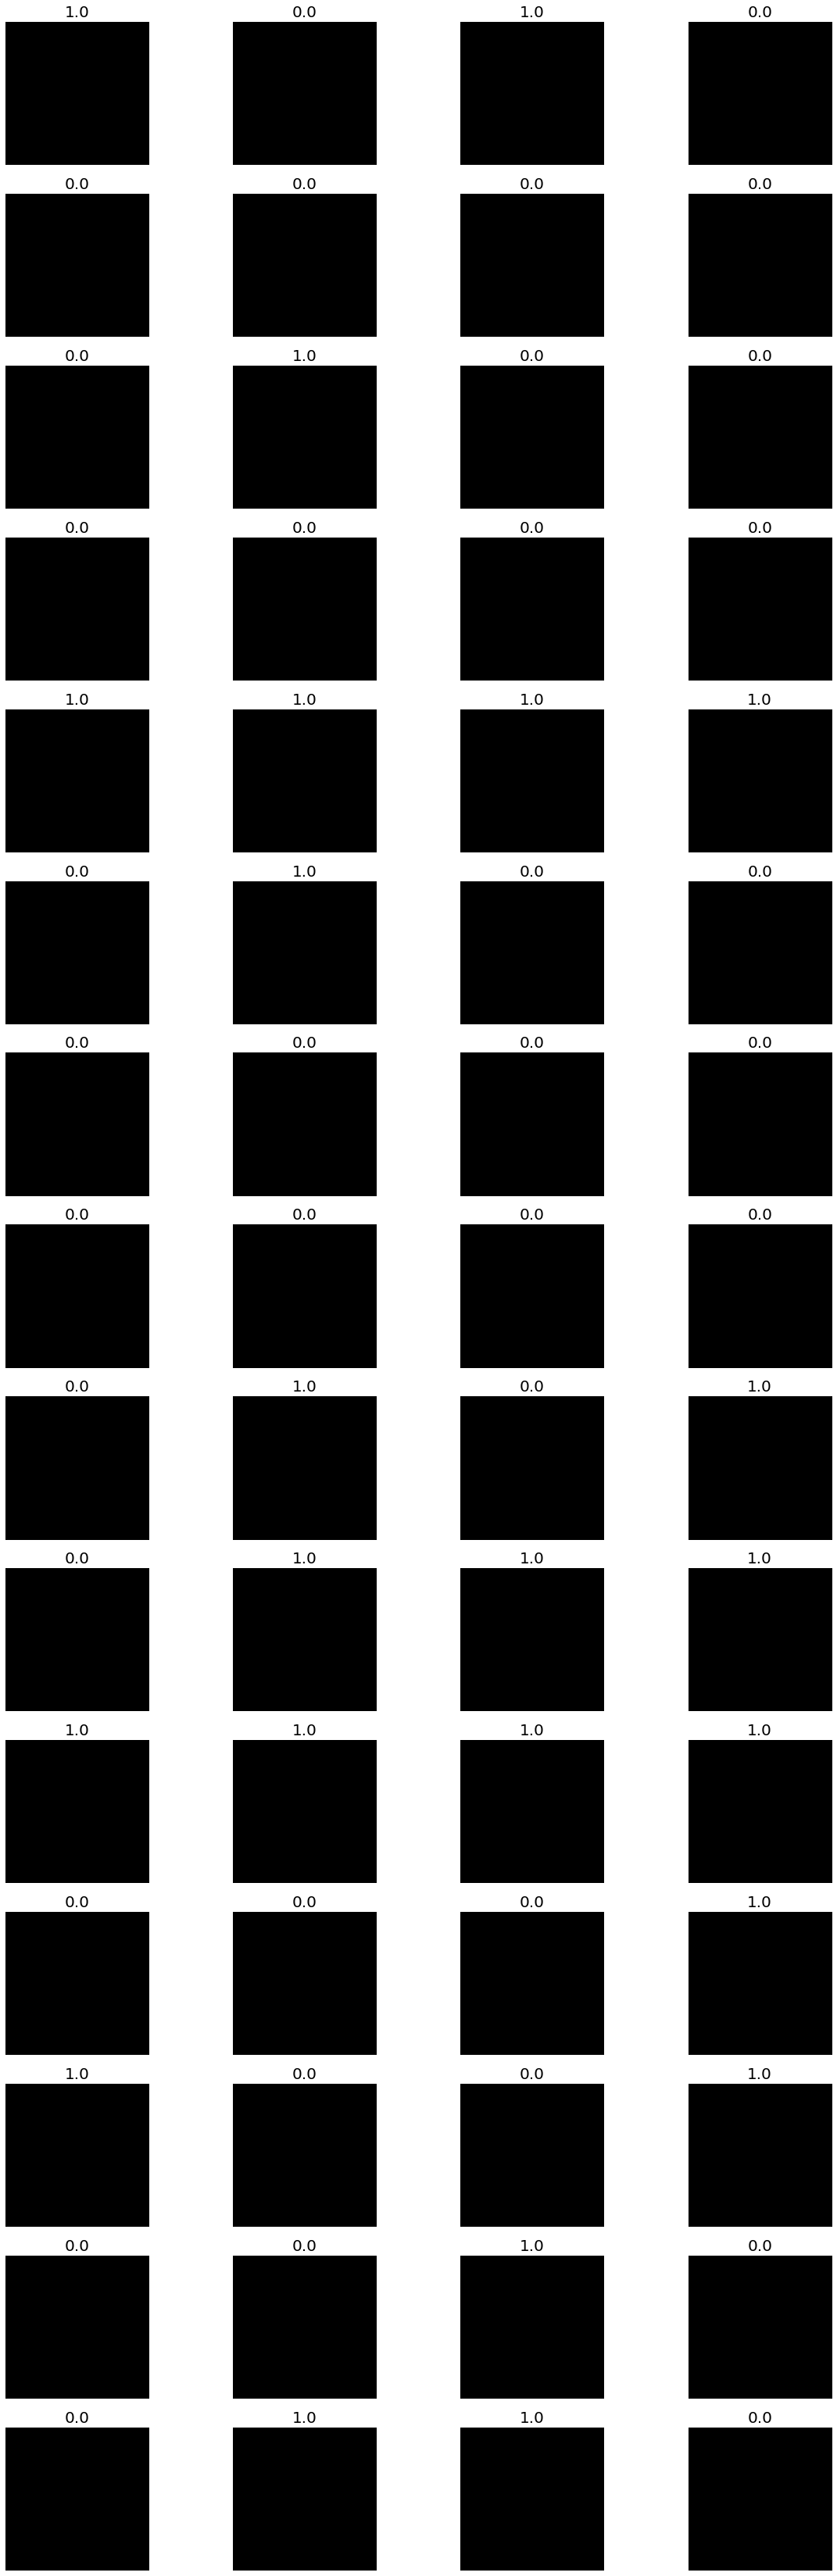

In [47]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(20,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where(((predictions[i])[0])>0.5,1.0,0.0)
  plt.imshow((img_pred_label*255.0).astype(np.uint8))
  plt.title(f"{eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


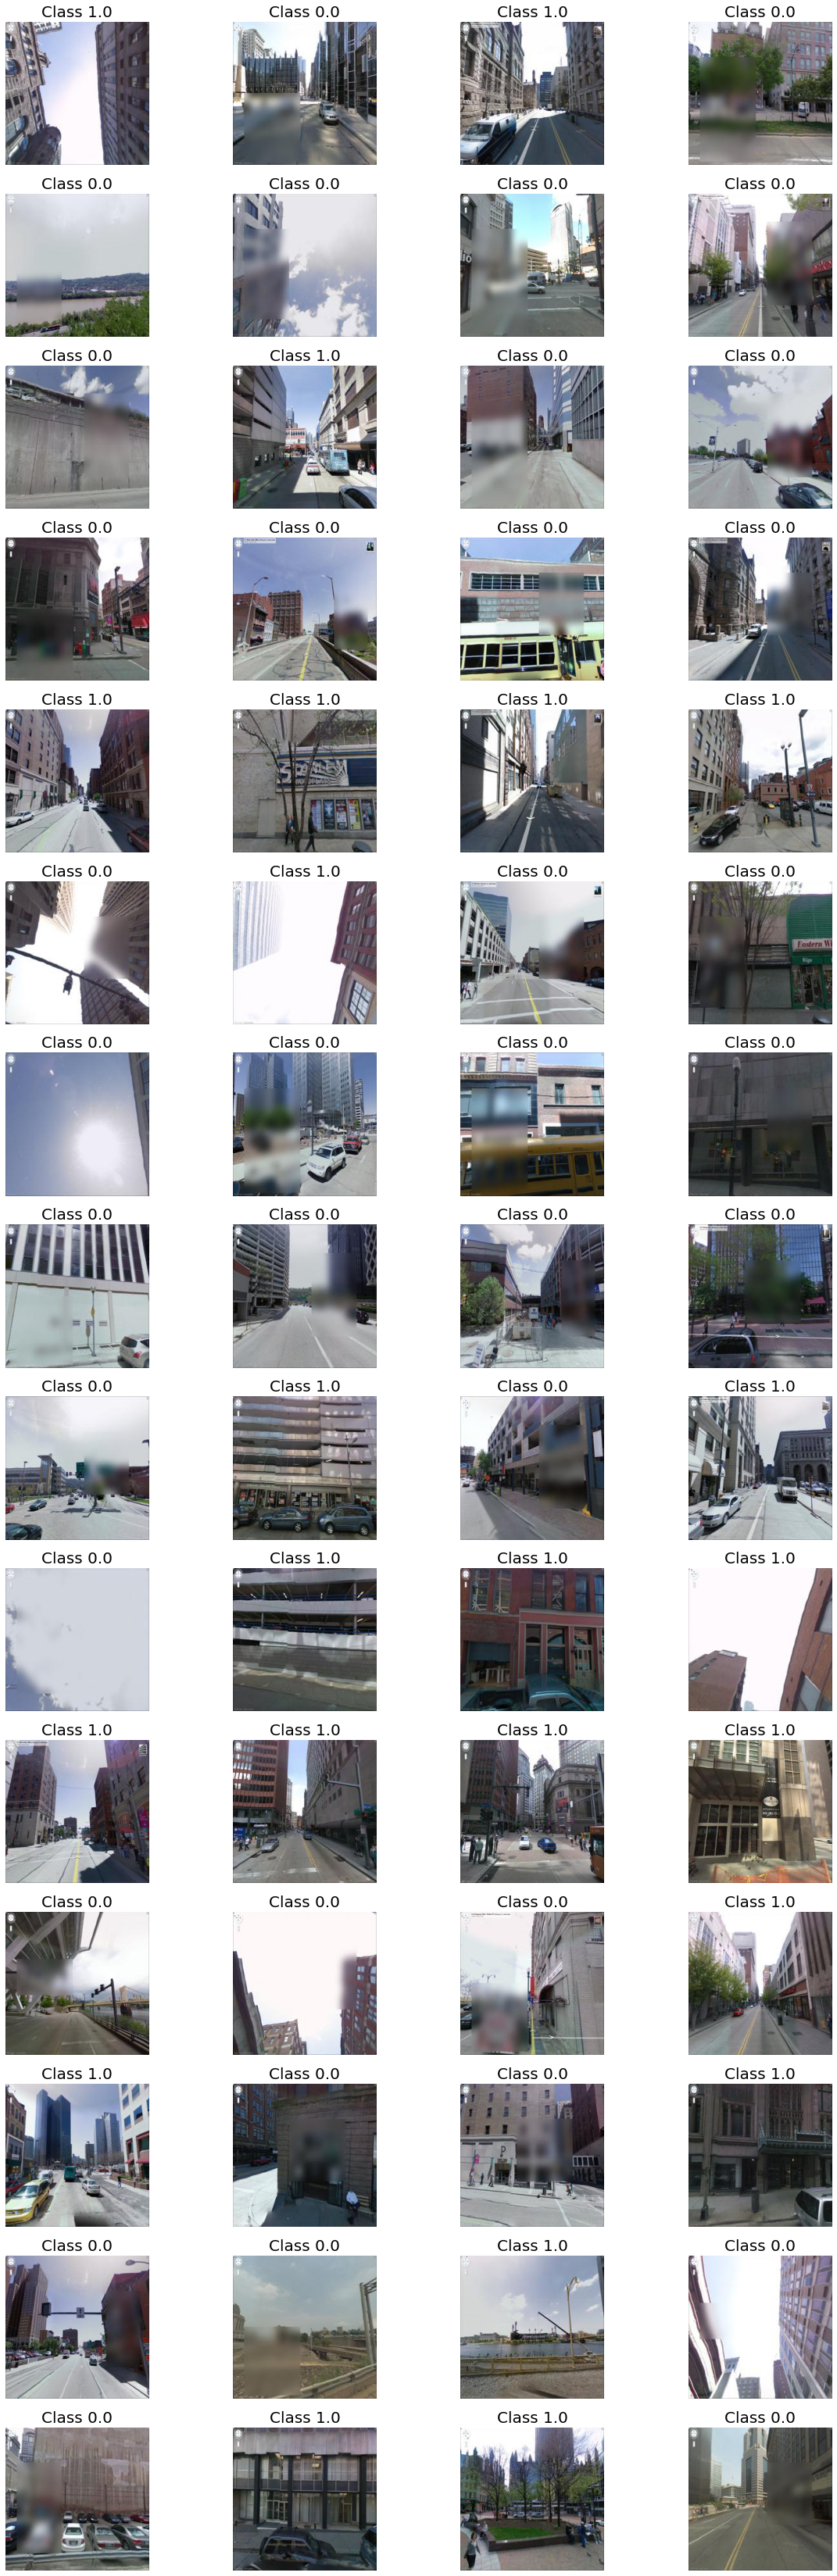

In [28]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0]))>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  plt.imshow(mask,cmap='binary')
  plt.title(f"Class {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()